# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import project_tests as t
import pickle

%matplotlib inline

df_original = pd.read_csv('data/user-item-interactions.csv')
df = df_original.copy()
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [3]:
print(f'Shape of df: {df.shape}')
print(f'Shape of df_content: {df_content.shape}')

Shape of df: (45993, 3)
Shape of df_content: (1056, 5)


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [4]:
# Common plot functions

def plot_hist(data, title, xlabel, ylabel, bins=100):
    '''
    Plots the histogram.
    
    INPUT:
    data - (pandas series) input data to plot
    title - (pandas dataframe) title of histogram
    xlabel - (string) label of x-axis
    ylabel - (string) label of y-axis
    bins - (int) number of histogram's bins   
    '''
    plt.figure(figsize = (20,4))
    plt.hist(data, facecolor='orange', edgecolor='white', bins=bins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
    
def plot_boxplot(data):
    '''
    Plots the boxplot.
    
    INPUT:
    data - (pandas series) input data to plot    
    '''
    plt.figure(figsize=(30,3))
    sns.set(style="whitegrid")
    ax = sns.boxplot(x=data)
    

### User-article interactions

In [5]:
# The number of times each user interacts with an article.
user_interacts = df['email'].value_counts()
user_interacts.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: email, dtype: float64

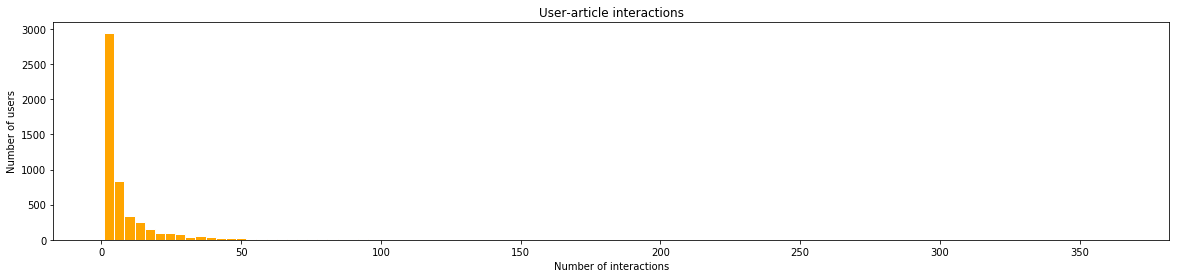

In [6]:
# Histogram of distribution of user-article interactions
plot_hist(user_interacts, 'User-article interactions', 'Number of interactions', 'Number of users')

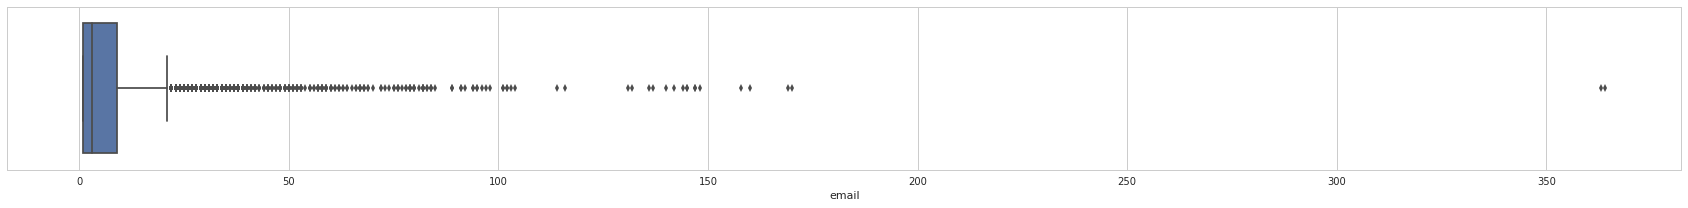

In [7]:
# Boxplot of distribution of user-article interactions
plot_boxplot(user_interacts)

In [8]:
print(f'mean: {user_interacts.mean()}')
print(f'median: {user_interacts.median()}')
print(f'mode: {user_interacts.mode()[0]}')

mean: 8.930846930846931
median: 3.0
mode: 1


### Summary on user-article interactions

The interactions has the lower bound of 1 - user interacts with a single article - which is also *the most frequent* interaction type in our dataset (*mode = 1*). More the number of interactions grows less users interacts. The relations between the statistical values of **mean**, **median**, and **mode** can be expressed as:

    mean > median > mode
    
We can see that the distribution of the user-article interactions is extremely **right-skewed**. This type of distribution will introduce great level of randomness when calculating similarity between the users: the users with few interactions have *few matching points*, consequently, the similarity of these users turns out to be very random.    

### Article-user interactions

In [9]:
# The number of times each article interacts with a user.
article_interacts = df['article_id'].value_counts()
article_interacts.describe()

count    714.000000
mean      64.415966
std      109.175923
min        1.000000
25%        8.000000
50%       25.000000
75%       69.000000
max      937.000000
Name: article_id, dtype: float64

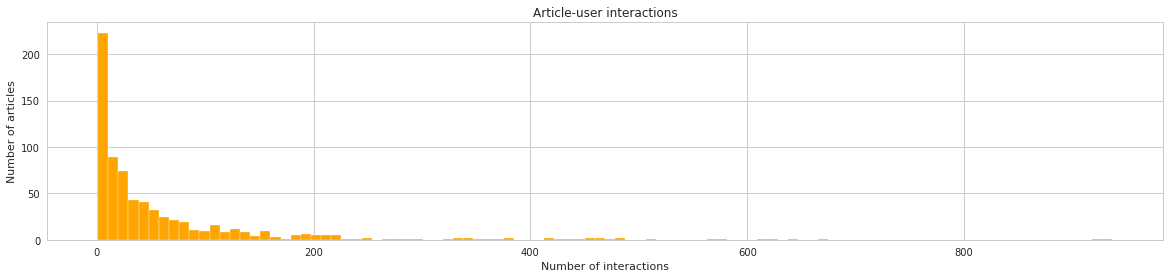

In [10]:
# Histogram of distribution of user-article interactions
plot_hist(article_interacts, 'Article-user interactions', 'Number of interactions', 'Number of articles')

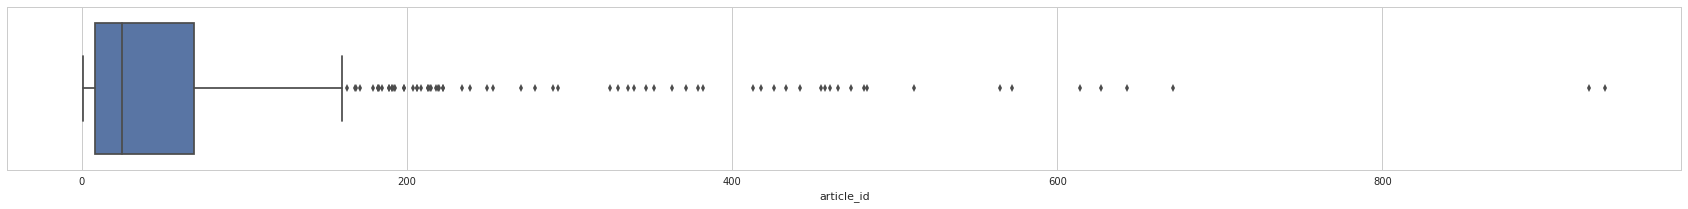

In [11]:
# Boxplot of distribution of article-user interactions
plot_boxplot(article_interacts)

In [12]:
print(f'mean: {article_interacts.mean()}')
print(f'median: {article_interacts.median()}')
print(f'mode: {article_interacts.mode()[0]}')

mean: 64.41596638655462
median: 25.0
mode: 2


### Summary on article-user interactions

The distribution of article-user interactions is **right-skewed** too but slightly less extreme than with the user-article interactions. This distribution will have less impact on our project since it has very limited influence on rank-based recommendations and user-user collaboration. 


### Missing values

In [13]:
print('-------------------------------------')
print('  [df] - Missing values per columns')
print('-------------------------------------')
print(f'Dataset row count: {df.shape[0]}')
print(df.isnull().sum())

-------------------------------------
  [df] - Missing values per columns
-------------------------------------
Dataset row count: 45993
article_id     0
title          0
email         17
dtype: int64


In [14]:
print('---------------------------------------------')
print('  [df_content] - Missing values per columns')
print('---------------------------------------------')
print(f'Dataset row count: {df_content.shape[0]}')
print(df_content.isnull().sum())

---------------------------------------------
  [df_content] - Missing values per columns
---------------------------------------------
Dataset row count: 1056
doc_body           14
doc_description     3
doc_full_name       0
doc_status          0
article_id          0
dtype: int64


### Data referential integrity check

Let's check if the data sets can be joined proiperly by the key - **article_id**. 

In [15]:
# Check the max values [df]
df['article_id'].max()

1444.0

In [16]:
# Check the max values [df_content]
df_content['article_id'].max()

1050

It looks like the data integrity is compromised. There is *at least one* article in the interactions data set that does not exists in the content dataset.

In [17]:
df[df['article_id'] == 1444.0]

,article_id,title,email
2374,1444.0,worldwide fuel oil consumption by household (i...,fd824fc62b4753107e3db7704cd9e8a4a1c961f1
17095,1444.0,worldwide fuel oil consumption by household (i...,d5843ed71361c87b364f578f20a48101289d60f9
21382,1444.0,worldwide fuel oil consumption by household (i...,d313c83ab3ed388ba16042a6cd33fce57d6a9e9a
27402,1444.0,worldwide fuel oil consumption by household (i...,c45f9495a76bf95d2633444817f1be8205ad542d
30249,1444.0,worldwide fuel oil consumption by household (i...,6cce7568da5452718e1a3702edffac34a8da74ec


In [18]:
df_content[df_content['article_id'] == 1444]

,doc_body,doc_description,doc_full_name,doc_status,article_id


Let's find how many articles in the *df* data set cannot be paired with articles in the *df_content* data set. 

In [19]:
# Join both data sets using left outer join to retain non-joined articles (from df_content)
joined = df.merge(df_content, on='article_id', how='left')
print(joined.shape)
joined.tail(3)

(46284, 7)


,article_id,title,email,doc_body,doc_description,doc_full_name,doc_status
46281,233.0,bayesian nonparametric models – stats and bots,4faeed980a7cd11e0f3cf2058cc04daa2ef11452,Homepage Stats and Bots Follow Sign in / Sign ...,An introduction to Bayesian Nonparametrics: th...,Bayesian Nonparametric Models – Stats and Bots,Live
46282,1160.0,analyze accident reports on amazon emr spark,abbf639ba05daa5249c520e290283a6d726ba78d,NaN,NaN,NaN,NaN
46283,16.0,higher-order logistic regression for large dat...,1f18e8aaccd6c8720180c3fe264c8aef5b00697f,* Home\r\n * Research\r\n * Partnerships and C...,The performance of supervised predictive model...,Higher-order Logistic Regression for Large Dat...,Live


In [20]:
# Get unique unpaired article_id from df:
unpaired = joined[joined['doc_status'].isnull()]['article_id'].unique()
print(f'Unpaired articles: {unpaired.shape[0]}')
np.sort(unpaired)

Unpaired articles: 277


array([ 1051.,  1052.,  1053.,  1054.,  1055.,  1056.,  1057.,  1058.,
        1059.,  1060.,  1061.,  1062.,  1063.,  1064.,  1065.,  1066.,
        1067.,  1068.,  1069.,  1070.,  1071.,  1072.,  1073.,  1074.,
        1075.,  1077.,  1078.,  1079.,  1080.,  1083.,  1084.,  1085.,
        1086.,  1089.,  1091.,  1092.,  1097.,  1101.,  1106.,  1108.,
        1112.,  1113.,  1114.,  1116.,  1119.,  1120.,  1121.,  1122.,
        1123.,  1124.,  1125.,  1127.,  1128.,  1130.,  1134.,  1135.,
        1137.,  1138.,  1139.,  1140.,  1141.,  1142.,  1143.,  1144.,
        1145.,  1146.,  1147.,  1148.,  1149.,  1150.,  1151.,  1152.,
        1153.,  1154.,  1155.,  1156.,  1157.,  1158.,  1159.,  1160.,
        1161.,  1162.,  1163.,  1164.,  1165.,  1166.,  1167.,  1168.,
        1169.,  1170.,  1171.,  1172.,  1173.,  1174.,  1175.,  1176.,
        1177.,  1178.,  1179.,  1180.,  1181.,  1183.,  1184.,  1185.,
        1186.,  1187.,  1188.,  1189.,  1190.,  1191.,  1192.,  1195.,
      

### Summary on data referential integrity check

There are **277** articles in the *interactions* data set that are not paired with the articles from the *content* data set. For every unpaired article it holds that 

    unpaired_article_id > 1050 

which is the last article_id in the *content* data set. This leads to conclusion that *there should be some missing data in the content data set*. Being so, **we should avoid joining the data sets**. This shouldn't be a problem since the *interactions* data set contains also the article's *title* - enough data for our project.  

In [21]:
# Fill in the median and maximum number of user_article interactios below

# 50% of individuals interact with ____ number of articles or fewer.
median_val = user_interacts.median() 

# The maximum number of user-article interactions by any 1 user is ______.
max_views_by_user = user_interacts.max()

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [22]:
# Find and explore duplicate articles

duplicates = df_content.duplicated(subset=['article_id'])
num_duplicates = (duplicates == True).sum()
print(f' Number of duplicates: {num_duplicates}')
print('-------------------------')
df_content.loc[duplicates]

 Number of duplicates: 5
-------------------------


,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [23]:
# Remove any rows that have the same article_id - only keep the first

In [24]:
df_content = df_content.drop_duplicates(subset='article_id')
df_content.shape

(1051, 5)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [25]:
# The number of unique articles that have at least one interaction with user
unique_articles = pd.unique(df['article_id']).shape[0]

# The number of unique articles on the IBM platform
total_articles = df_content[df_content['article_id'].notnull()].shape[0]

# The number of unique users
unique_users = pd.unique(df[df['email'].notnull()]['email']).shape[0]

# The number of user-article interactions
user_article_interactions = df.shape[0]

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [26]:
# Get the most viewed article
most_viewed_article = df.groupby('article_id')['article_id'].count().sort_values(ascending=False).head(1)

# The most viewed article in the dataset as a string with one value following the decimal 
most_viewed_article_id = str(most_viewed_article.index[0])

# The most viewed article in the dataset was viewed how many times?
max_views = most_viewed_article.values[0]

In [27]:
# Show statistical data

stat = pd.DataFrame(
    data = [
        user_article_interactions,
        max_views_by_user,
        max_views,
        most_viewed_article_id,
        unique_articles,
        unique_users,
        total_articles
    ],
    columns = ['statistical value'],
    index = [
        'interactions count', 
        'max interactions by user',
        'max views',
        'most viewed article',
        'viewed articles count',
        'unique users count',
        'unique articles count'
    ])
stat

,statistical value
interactions count,45993
max interactions by user,364
max views,937
most viewed article,1429.0
viewed articles count,714
unique users count,5148
unique articles count,1051


In [28]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [29]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [30]:
def get_top_article_data(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - A DataFrame of the top 'n' article titles with
                   columns: 
                       - article_id,
                       - title
                       - count (number of article views)
    
    '''
    data = df.groupby(['article_id', 'title']).count().reset_index()
    data = data.rename({ 'user_id': 'count'}, axis=1) 
    
    return data.sort_values(by='count', ascending=False).iloc[0:n, :]
    

def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Return the top article titles from df (not df_content)
    return list(get_top_article_data(n).iloc[:, 1])


def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Return the top article ids
    return [str(i) for i in get_top_article_data(n)['article_id']]


In [31]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [32]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [33]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    df2 = df[['user_id','article_id']].set_index('user_id')
    df2['value'] = 1
    user_item = pd.pivot_table(df2, values='value', index='user_id', 
                               columns='article_id', aggfunc=np.min, fill_value=0)
    
    # return the user_item matrix 
    return user_item


user_item = create_user_item_matrix(df)

In [34]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [35]:
# It is recommended to execute this function apart in order to offer already
# calculated user_matrix as an argument to other recommendation functions.

def create_user_matrix(user_item=user_item):
    '''
    Computes the similarity of every pair of users based on the dot product.
    INPUT
    user_item - (pandas dataframe) matrix of users by articles: 
        1's when a user has interacted with an article, 0 otherwise
    OUTPUT: 
    The similarity matrix.
    '''
    # Create matrix using dot product
    user_matrix = np.dot(user_item, user_item.T)
    
    return user_matrix


In [36]:
# Create user matrix (time consuming)
user_matrix = create_user_matrix()
user_matrix.shape

(5149, 5149)

In [37]:
def find_similar_users(user_id, user_matrix=user_matrix, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_matrix - matrix of similarity between users          
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    '''
    # get user vektor (row)
    user_vector = user_matrix[user_id - 1] # decrease user_id to obtain matrix index
    
    # create Series using user_vektor and corresponding user_id indices
    user_data = pd.Series(user_vector.T, index=user_item.index)
    
    # remove self-user and sort by descending order
    user_data = user_data[user_data.index != user_id].sort_values(ascending=False)
    
    # exclude zero similarity
    most_similar_users = user_data[user_data > 0]
    
    return list(most_similar_users.index) # return a list of the users in order from most to least similar
        

In [38]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 3697]
The 5 most similar users to user 3933 are: [1, 3782, 23, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

1. Find similar users of @user_id
2. For each similar user:
    2.1 Find new articles for @user_id
   Until i = m





In [39]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    articles = df.groupby('article_id')['title'].min()
    article_names = articles[articles.index.isin(article_ids)].values.tolist()
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    ids = np.array((user_item.loc[user_id, user_item.loc[user_id] == 1].index))
    article_ids = [str(i) for i in ids]  
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Get user's articles
    user_article_ids, user_article_names = get_user_articles(user_id)
    user_article_ids_set = set(user_article_ids)
    
    # Find similar users
    similar_users = find_similar_users(user_id)

    # Loop through the similar users
    recs = []
    for similar_id in similar_users:
        if len(recs) < m:      
            # Get articles of current similar user
            article_ids, article_names = get_user_articles(similar_id)
            
            # Get diff articles (option A)
            diff_ids = set(article_ids).difference(user_article_ids_set)
            
            # The diff articles (option B) - gives different result
            # diff_ids = np.setdiff1d(np.array(article_ids), np.array(user_article_ids))
            
            recs.extend(list(diff_ids))
        else:
            break
    
    return recs[:m] # return your recommendations for this user_id   


In [40]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['higher-order logistic regression for large datasets',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 'a dynamic duo – inside machine learning – medium',
 'python machine learning: scikit-learn tutorial',
 'easy json loading and social sharing in dsx notebooks',
 'brunel interactive visualizations in jupyter notebooks',
 'a tensorflow regression model to predict house values',
 'analyze open data sets with spark & pixiedust',
 '54174    detect potentially malfunctioning sensors in r...\nName: title, dtype: object',
 'the nurse assignment problem']

In [41]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [42]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Create neighbors dataframe
    neighbors_df = pd.DataFrame(
        data = {
            'neighbor_id': user_item.index,
            'similarity': user_matrix[user_id - 1]
        },
        index = user_item.index
    )
    
    # Exclude self user
    neighbors_df = neighbors_df[neighbors_df['neighbor_id'] != user_id]
    
    # Calc all user interactions with items
    all_interactions = df.groupby(['user_id'])['article_id'].count()
    
    # Add number of interactions for neighbor user
    neighbors_df['num_interactions'] = neighbors_df['neighbor_id'] \
        .apply(lambda x: all_interactions.loc[x])
    
    # Return the ordered dataframe specified in the doc_string
    return neighbors_df \
        .sort_values(by=['similarity', 'num_interactions'], ascending=False)


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Calc all article interactions
    all_article_interact = df.groupby(['article_id'])['article_id'].count()
    
    # Get user's articles
    user_article_ids, user_article_names = get_user_articles(user_id)
    user_article_ids_set = set(user_article_ids)
    
    # Find similar users
    similar_users_df = get_top_sorted_users(user_id)

    # Loop through the similar users
    recs = []
    for similar_id in similar_users_df['neighbor_id']:
        if len(recs) < m:      
            # Get articles of current similar user
            article_ids, article_names = get_user_articles(similar_id)
            
            # Get diff articles (option A)
            diff_ids = set(article_ids).difference(user_article_ids_set)
            
            # Articles with the most total interactions first
            articles = all_article_interact[all_article_interact.index.astype(str).isin(diff_ids)]
            
            # Add all articles, we'll use slicing later
            recs.extend(articles.sort_values(ascending=False).index.values.astype(str))

        else:
            break
    
    recs = recs[:m]
    rec_names = get_article_names(recs)
    
    return recs, rec_names  # return your recommendations for this user_id  
    

In [43]:
# Check first 5 recommendations for user #1
recs, rec_names = user_user_recs_part2(1, 5)
print(recs)
print(rec_names)

['1330.0', '1364.0', '1314.0', '1162.0', '1304.0']
['analyze energy consumption in buildings', 'gosales transactions for logistic regression model', 'healthcare python streaming application demo', 'insights from new york car accident reports', 'predicting churn with the spss random tree algorithm']


In [44]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1330.0', '1427.0', '1364.0', '1170.0', '1162.0', '1304.0', '1351.0', '1160.0', '1354.0', '1368.0']

The top 10 recommendations for user 20 are the following article names:
['analyze accident reports on amazon emr spark', 'analyze energy consumption in buildings', 'apache spark lab, part 1: basic concepts', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'model bike sharing data with spss', 'movie recommender system with spark machine learning', 'predicting churn with the spss random tree algorithm', 'putting a human face on machine learning', 'use xgboost, scikit-learn & ibm watson machine learning apis']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [45]:
### Tests with a dictionary of results

# Find the user that is most similar to user 1 
user1_most_sim = find_similar_users(1)[0]

# Find the 10th most similar user to user 131
user131_10th_sim = find_similar_users(131)[9]

In [46]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**

If the user is new, then we have no information about its profile and articles he/she read. Then we cannot use neither *user-user collaboration* nor *content-based recommendation* method. In that case we can only use **rank-based recommendations**. The user is recommended the articles that are ranked as *the top articles* in our data set. 

This method has one disadvantage: a "new user" is *any* new user, any new user will be recommended *the same content*. Nevertheless, that is what we have. If we don't have any user interactions there seem to be no other solution.  


`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [47]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 

# Your recommendations here
new_user_recs = get_top_article_ids(10)

In [48]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
def make_content_recs():
    '''
    INPUT:
    
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [49]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [50]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
user_item_matrix.shape

(5149, 714)

`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [52]:
# Perform SVD on the User-Item Matrix Here

# use the built in to get the three matrices
u, s, vt = np.linalg.svd(user_item_matrix)
u.shape, s.shape, vt.shape

((5149, 5149), (714,), (714, 714))

**Provide your response here.**

If we check the dimensions of the three returned objects, we can see that:

 - the *u* matrix is a square matrix with the same number of rows and columns = 5149 users
 - the *sigma* matrix should be a diagonal matrix but it returned an array with 714 values
 - the *vt* matrix is, like the *u* matrix, a square matrix with the same number of rows and columns = 714 movies 

We were expecting that the u matrix would have the shape (5147, k), the *sigma* matrix (k, k), and the *vt* matrix (k, 714), where *k* is the number of latent features. 

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

In [198]:
user_item_matrix.shape

(5149, 714)

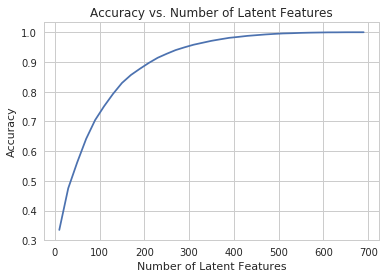

In [53]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [54]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''    
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)   
    test_idx = user_item_test.index
    test_arts = user_item_test.columns    
    
    return user_item_train, user_item_test, test_idx, test_arts


user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [55]:
print(user_item_train.shape, user_item_test.shape, test_idx.shape, test_arts.shape)

(4487, 714) (682, 574) (682,) (574,)


In [56]:
# 1. How many users can we make predictions for in the test set?
# = users that are in the training AND testing data set
v1 = np.intersect1d(user_item_train.index, user_item_test.index).shape[0]
v1

20

In [57]:
# 2. How many users in the test set are we not able to make predictions for because of the cold start problem?
# = test users that are not in the training data set
v2 = user_item_test.index.shape[0] - v1
v2

662

In [58]:
# 3. How many articles can we make predictions for in the test set?
# = articles that are in training AND testing data set
v3 = np.intersect1d(user_item_train.columns, user_item_test.columns).shape[0]
v3

574

In [59]:
# 4. How many articles in the test set are we not able to make predictions for because of the cold start problem?
# = test articles that are not in the training data set
v4 = user_item_test.columns.shape[0] - v3
v4

0

In [60]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 

sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [61]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)
u_train.shape, s_train.shape, vt_train.shape

((4487, 4487), (714,), (714, 714))

In [ ]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

In [147]:
def get_ixs(subset_df, set_df):
    '''
    Finds indexes for users and articles of the subset data set against all data set.
    
    INPUT:
    subset_df - subset dataframe with interactions 
    set_df - set dataframe with iteractions
    
    OUTPUT:
    users_ix - ndarray with indexes for test users  
    articles_ix - ndarray with indexes for test articles 
    '''
    
    users_ix = np.where(np.in1d(np.array(set_df.index), np.array(subset_df.index)))[0]
    articles_ix = np.where(np.in1d(np.array(set_df.columns), np.array(subset_df.columns)))[0]
    
    return users_ix, articles_ix


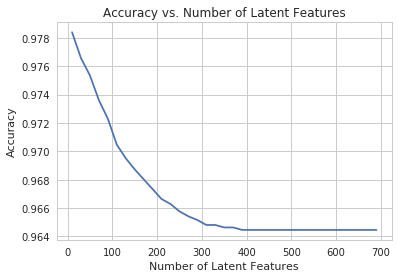

In [181]:
num_latent_feats = np.arange(10, 710, 20)
sum_errs = []

# get indexes for test users & articles
users_ix, articles_ix = get_ixs(test_set, user_item_train) 

# calc number of interactions
n_interacts = len(users_ix) * len(articles_ix)  

for k in num_latent_feats:
      
    # restructure with k latent features
    s_train_new, u_train_new, vt_train_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    s_test_new, u_test_new, vt_test_new = s_train_new, u_train_new[users_ix, :], vt_train_new[:, articles_ix]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_test_new, s_test_new), vt_test_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(test_set, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    

plt.plot(num_latent_feats, 1 - np.array(sum_errs)/n_interacts);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

In [199]:
# Calc first and last accuracy:
first_accuracy = 1 - sum_errs[0]/n_interacts
last_accuracy = 1 - sum_errs[-1]/n_interacts

print(f'Accuracy: {round(first_accuracy * 100, 2)} -> {round(last_accuracy * 100, 2)}')

Accuracy: 97.84 -> 96.45


`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**

When we used entire user-item interaction data our Accuracy/Latent features curve was flipped vertically: the accuracy increases as the number of latent feature increases (until reaching a certain point). Then we decided to split our dataset into a training and test set which has given us almost the opposite result.

Inspite the overall high accuracy our model shows that by increasing the latent features the accuracy decreases until it gets stabilized at around 96.45%. The fall of accuracy may be a result of a small data variability since we only have 20 test users and 218 user-item interactions with 1's representation in the test data set. By adding more latent features the data split becomes higher, so we lack more interaction data to achieve better prediction.

We could improve our recommendation system by using other recommendation methods like content based recommendation or collaborative filtering.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])